<a href="https://colab.research.google.com/github/cindmichelle/mask_rcnn_istar/blob/master/results/epochs/istar_epochs_1_head_2_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

Using : 
*   Conf Level = 0.7
*   Train using epoch 1, head layer only



**NOTE** : *if you running this on Google Colab, don't forget to change runtime type to GPU, so there will be no more time wasted because Google Colab run in TPU by default*

In [0]:
# %cd
# %cd ../content
# %rm -rf Mask_RCNN/

/root
/content


In [1]:
!git clone https://github.com/cindmichelle/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 976, done.
remote: Total 976 (delta 0), reused 0 (delta 0), pack-reused 976
Receiving objects: 100% (976/976), 111.86 MiB | 39.66 MiB/s, done.
Resolving deltas: 100% (582/582), done.


In [0]:
pwd

'/content'

In [2]:
from google.colab import drive  
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd
%cd ../content/drive/"My Drive"/"dataset zip"/"all"

/root
/content/drive/My Drive/dataset zip/all


In [0]:
import zipfile

zip_ref = zipfile.ZipFile('dataset_04_05_1.zip', 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [0]:
import zipfile

zip_ref = zipfile.ZipFile('dataset_04_14_test.zip', 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [0]:
# %cd
# %cd ../content/
# %rm -rf dataset_04_14_test
# %rm -rf dataset_04_05_1/val/

In [6]:
%cd
%cd ../content/dataset_04_05_1
%mkdir val

/root
/content/dataset_04_05_1


In [7]:
%cd
%cd ../content/drive/"My Drive"/"dataset zip"/

/root
/content/drive/My Drive/dataset zip


In [0]:
import zipfile

zip_ref = zipfile.ZipFile('logs.zip', 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [9]:
%cd
%cd ../content/
%mkdir logs
%cp -r  ./shapes20200414T0653/ ./logs/shapes20200414T0653

/root
/content


## Install Keras 2.1.6
To allow multi GPU Processing

In [10]:
%pip install keras==2.1.6

     |████████████████████████████████| 348kB 4.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [11]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [12]:
pip freeze

absl-py==0.9.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
asgiref==3.2.7
astor==0.8.1
astropy==4.0.1.post1
astunparse==1.6.3
atari-py==0.2.6
atomicwrites==1.3.0
attrs==19.3.0
audioread==2.1.8
autograd==1.3
Babel==2.8.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.4
blis==0.4.1
bokeh==1.4.0
boto3==1.12.38
botocore==1.15.38
Bottleneck==1.3.2
branca==0.4.0
bs4==0.0.1
bz2file==0.98
CacheControl==0.12.6
cachetools==3.1.1
catalogue==1.0.0
certifi==2020.4.5.1
cffi==1.14.0
chainer==6.5.0
chardet==3.0.4
click==7.1.1
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.4.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==6.5.0
cvxopt==1.2.4
cvxpy==1.0.29
cycler==0.10.0
cymem==2.0.3
Cython==0.29.16
daft==0.0.4
dask==2.12.0
dataclasses==0.7
datascience==0.10.6
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.1.1
distributed

In [13]:
%cd
%cd ../content/Mask_RCNN/

/root
/content/Mask_RCNN


## Initialization

In [14]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw
import json
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


Using TensorFlow backend.


... done downloading pretrained model!


In [0]:
pwd

'/content/Mask_RCNN'

## Config

In [15]:
class IstarConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    GPU_COUNT = 1
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 5  # Background + 5 istar elements + 2 istar actor types

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    # IMAGE_MIN_DIM = 1024
    # IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # TRAIN_ROIS_PER_IMAGE = 32
  
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

     # use small validation steps since the epoch is small
    # VALIDATION_STEPS = 5

config = IstarConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [0]:
from skimage.transform import rotate

class IstarDataset(utils.Dataset):

    def load_istar(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # TODO : Add more classes if test success (Goal, Actor, Quality).
        self.add_class("shapes", 1, "Actor")
        self.add_class("shapes", 2, "Goal")
        self.add_class("shapes", 3, "Quality")
        self.add_class("shapes", 4, "Task")
        self.add_class("shapes", 5, "Resource")
        
        # self.add_class("type", 6, "Role")
        # self.add_class("type", 7, "Agent")
        # self.add_class("type", 8, "Unknown")
        


        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotationsDict = json.load(open(os.path.join(dataset_dir, "annotations.json")))
        annotationsArr = list(annotationsDict.values())  # don't need the dict keys

        
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotationsArr if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            # print('filename ', a['filename'])
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            objects = [s['region_attributes'] for s in a['regions'].values()]

            ## NOTE : this contains label of the objects
            class_ids_name = [int(n['element_name']) for n in objects]
            # class_ids_type = [int(n['element_type']) for n in objects]

			# load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            # print("multi_numbers=", multi_numbers)
            # num_ids = [n for n in multi_numbers['number'].values()]
            # for n in multi_numbers:
            
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path, plugin='pil')
            isLandscape= a['file_attributes']['landscape']
            height, width = image.shape[:2]

            if isLandscape :
              if a['filename'] == '20200218_165243_noise_test.jpg' : 
                print(a['filename'], height, width)

              if width < height :
                if a['filename'] == '20200218_165243_noise_test.jpg' : 
                  print('should be rotate')
                image = rotate(image, 90, resize=True)
                height, width = image.shape[:2]
                
                if a['filename'] == '20200218_165243_noise_test.jpg' : 
                  print('after rotate (h,w) : ', height, width)

                # print("should be rotate into landscape")
            
            else : #if portrait
              if height < width : 
                image = rotate(image, 90, resize=True)
                height, width = image.shape[:2]
                # print("should be rotate into portrait")

            self.add_image(
                "shapes",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
				class_ids=class_ids_name)

        #     self.add_image(
        #         "type",
        #         image_id=a['filename'],  # use file name as a unique image id
        #         path=image_path,
        #         width=width, height=height,
        #         polygons=polygons,
				# class_ids=class_ids_type)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]

        # print("IMAGE INFO :", image_info)
        if image_info["source"] != "shapes" :
            return super(self.__class__, self).load_mask(image_id)
        class_ids = image_info['class_ids']
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            if p['name'] == 'polyline':
              rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            elif p['name'] == 'circle':
              rr, cc = skimage.draw.circle(p['cy'], p['cx'], p['r'])
            # rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        #class_ids=np.array([self.class_names.index(shapes[0])])
        # print("info['class_ids']=", info['class_ids'])
        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


## Prepare Dataset for Training and Validation

In [0]:
# Training dataset
dataset_train = IstarDataset()
dataset_train.load_istar("../dataset_04_05_1/", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = IstarDataset()
dataset_val.load_istar("../dataset_04_05_1/", "val")
dataset_val.prepare()

## Load and display random samples

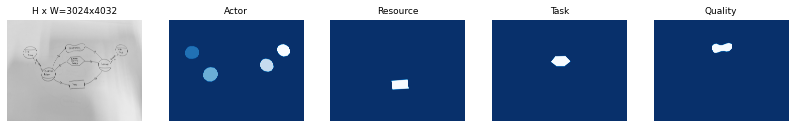

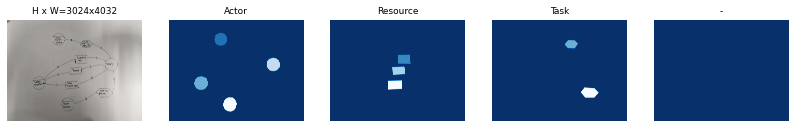

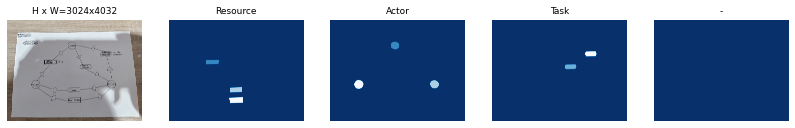

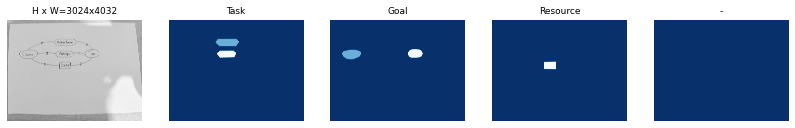

In [25]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    # print("dataset['class_names']", dataset_train.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [0]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [0]:
%pip freeze

In [38]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
      # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 1


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [28]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
# TODO :  find out difference between train only on heads layer and all layers
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/shapes20200416T1159/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/1
 99/100 [============================>.] - ETA: 1s - loss: 1.8681 - rpn_class_loss: 0.0947 - rpn_bbox_loss: 0.2655 - mrcnn_class_loss: 0.5783 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.5423

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 259s 3s/step - loss: 1.8621 - rpn_class_loss: 0.0940 - rpn_bbox_loss: 0.2643 - mrcnn_class_loss: 0.5773 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.5409 - val_loss: 1.0700 - val_rpn_class_loss: 0.0121 - val_rpn_bbox_loss: 0.1139 - val_mrcnn_class_loss: 0.3455 - val_mrcnn_bbox_loss: 0.2248 - val_mrcnn_mask_loss: 0.3736



In [39]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /content/logs/shapes20200416T1159/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b         

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 2/2
 99/100 [============================>.] - ETA: 2s - loss: 0.8843 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.3557

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 316s 3s/step - loss: 0.8836 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.3553 - val_loss: 0.6753 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.0586 - val_mrcnn_class_loss: 0.1572 - val_mrcnn_bbox_loss: 0.1021 - val_mrcnn_mask_loss: 0.3483


## Detection

In [40]:
class InferenceConfig(IstarConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # IMAGE_MIN_DIM = 1024
    # IMAGE_MAX_DIM = 1024

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
# model_path = '../logs/shapes20200414T0653/mask_rcnn_shapes_0030.h5'

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/logs/shapes20200416T1159/mask_rcnn_shapes_0002.h5
Re-starting from epoch 2


image_id 0
image_id                 shape: ()                    min:    0.00000  max:    0.00000  int64
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  245.00000  uint8
image_meta               shape: (18,)                 min:    0.00000  max: 4032.00000  float64
gt_class_id              shape: (8,)                  min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (8, 4)                min:  160.00000  max:  791.00000  int32
gt_mask                  shape: (1024, 1024, 8)       min:    0.00000  max:    1.00000  uint8


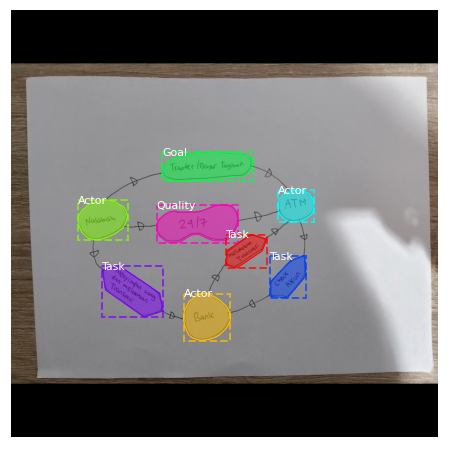

In [41]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
print("image_id", image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
log("image_id", image_id)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  245.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


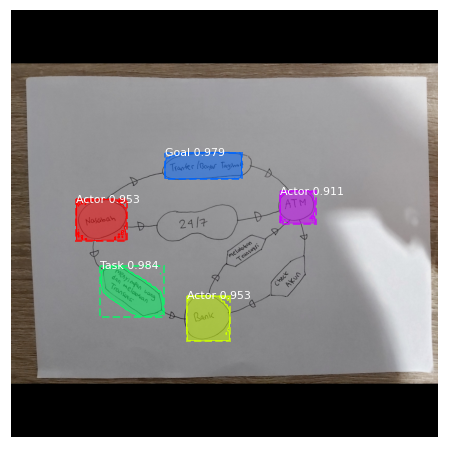

In [42]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

gt_match [ 2.  1.  4. -1.  0. -1. -1.  3.]
pred_match [4. 1. 0. 7. 2.]
pred_match > -1 (array([0, 1, 2, 3, 4]),)
cumsum of pred_match > -1 :  [1 2 3 4 5]
np.arange(len(pred_match)) + 1 :  [1 2 3 4 5]
precisions [1. 1. 1. 1. 1.]
len(gt_match) 8
recalls [0.125 0.25  0.375 0.5   0.625]
precisions after concatenate [0. 1. 1. 1. 1. 1. 0.]
recalls after concatenate [0.    0.125 0.25  0.375 0.5   0.625 1.   ]
range(len(precisions) - 2) range(0, 5)
range(len(precisions) - 2, -1, ) range(5, -1)
range(len(precisions) - 2, -1, -1) range(5, -1, -1)
precisions after loop :  [1. 1. 1. 1. 1. 1. 0.]
indices [1 2 3 4 5 6]
recalls[0 - 1] 1.0
mAP: 0.625
mAP:  0.625


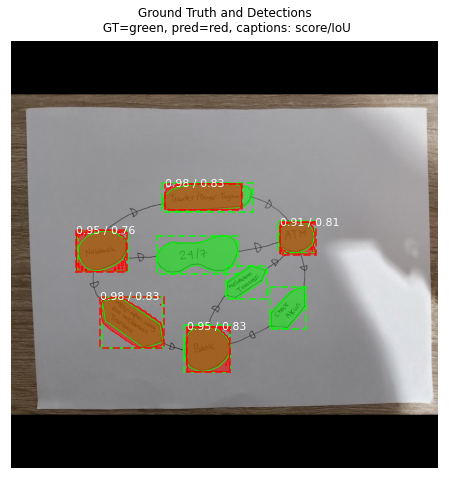

In [43]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 1)

# image_ids = [12]
APs = []

for image_id in image_ids:;./0;//.0/.0;p;;.9op;l;;;;;;;
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    
    # For debugging
    # print('image_id',image_id)
    # info = dataset_val.image_info[image_id]
    # print('image info ', info)
    # print('rois', r['rois'].shape)
    # print('gt_bbox', gt_bbox.shape)

    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    ax = get_ax()
    visualize.display_differences(image, gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'],r['scores'],r['masks'],
                              dataset_val.class_names,ax=ax)
    
print("mAP: ", np.mean(APs))